In [ ]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in /usr/local/lib/python3.7/dist-packages (0.0)


In [ ]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

In [1]:
import pandas as pd

# Read the CSV and Perform Basic Data Cleaning

In [2]:
df = pd.read_csv("exoplanet_data.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443,9.11,2.87,-1.62,25.8,2,5455,81,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638,39.30,31.04,-10.49,76.3,1,5853,158,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395,891.96,668.95,-230.35,505.6,1,5805,157,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406,926.16,874.33,-314.24,40.9,1,6031,169,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,-0.001900,0.762,0.139,-0.532,3.14020,0.06730,-0.06730,686.0,18.7,-18.7,2.77,0.90,-0.30,1160,427.65,420.33,-136.70,40.2,2,6046,189,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


# Select your features (columns)

In [3]:
# Set features. This will also be used as your x values.
selected_features = df.drop("koi_disposition", axis=1)
selected_features

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443,9.11,2.87,-1.62,25.8,2,5455,81,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638,39.30,31.04,-10.49,76.3,1,5853,158,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395,891.96,668.95,-230.35,505.6,1,5805,157,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406,926.16,874.33,-314.24,40.9,1,6031,169,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,-0.001900,0.762,0.139,-0.532,3.14020,0.06730,-0.06730,686.0,18.7,-18.7,2.77,0.90,-0.30,1160,427.65,420.33,-136.70,40.2,2,6046,189,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6986,0,0,0,1,8.589871,1.846000e-04,-1.846000e-04,132.016100,0.015700,-0.015700,0.765,0.023,-0.541,4.80600,0.63400,-0.63400,87.7,13.0,-13.0,1.11,0.32,-0.23,929,176.40,152.77,-77.60,8.4,1,5638,169,-152,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
6987,0,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,0.000170,-0.000170,1.252,0.051,-0.049,3.22210,0.01740,-0.01740,1579.2,4.6,-4.6,29.35,7.70,-2.57,2088,4500.53,3406.38,-1175.26,453.3,1,5638,139,-166,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
6988,0,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,0.007690,-0.007690,0.043,0.423,-0.043,3.11400,0.22900,-0.22900,48.5,5.4,-5.4,0.72,0.24,-0.08,1608,1585.81,1537.86,-502.22,10.6,1,6119,165,-220,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
6989,0,0,1,0,0.681402,2.430000e-06,-2.430000e-06,132.181750,0.002850,-0.002850,0.147,0.309,-0.147,0.86500,0.16200,-0.16200,103.6,14.7,-14.7,1.07,0.36,-0.11,2218,5713.41,5675.74,-1836.94,12.3,1,6173,193,-236,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385


# Create a Train Test Split

Use `koi_disposition` for the y values

In [4]:
y = df["koi_disposition"]
X = selected_features
print(X.shape, y.shape)

(6991, 40) (6991,)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
6122,0,0,0,0,6.768901,7.380000e-05,-7.380000e-05,133.077240,0.008440,-0.008440,0.150,0.305,-0.150,3.61600,0.30600,-0.30600,123.1,13.2,-13.2,1.24,0.34,-0.23,1017,253.30,204.89,-103.87,10.8,1,5737,154,-171,4.327,0.153,-0.187,1.125,0.310,-0.207,294.40472,39.351681,14.725
6370,0,1,0,1,0.733726,6.060000e-06,-6.060000e-06,132.020050,0.007950,-0.007950,0.291,0.193,-0.291,2.30900,0.28200,-0.28200,114.6,9.3,-9.3,0.86,0.23,-0.06,1867,2891.64,2253.61,-677.78,13.8,1,5855,158,-175,4.578,0.033,-0.187,0.797,0.211,-0.056,284.50391,42.463860,15.770
2879,1,0,0,0,7.652707,6.540000e-05,-6.540000e-05,134.460380,0.006190,-0.006190,0.970,0.879,-0.942,79.89690,0.00000,0.00000,641.1,42.9,-42.9,3.21,0.97,-0.32,989,226.81,195.16,-64.34,254.3,1,6328,151,-189,4.481,0.050,-0.200,0.963,0.290,-0.097,295.50211,38.983540,13.099
107,0,0,0,0,7.953547,1.910000e-05,-1.910000e-05,174.662240,0.001820,-0.001820,0.300,0.145,-0.300,2.63120,0.05950,-0.05950,875.4,25.3,-25.3,2.25,0.07,-0.14,696,55.37,7.15,-10.12,38.4,1,4768,76,-85,4.536,0.056,-0.016,0.779,0.023,-0.049,291.15878,40.750271,15.660
29,0,0,0,0,4.959319,5.150000e-07,-5.150000e-07,172.258529,0.000083,-0.000083,0.831,0.016,-0.004,2.22739,0.00750,-0.00750,9802.0,20.0,-20.0,12.21,1.96,-1.46,1103,349.40,146.52,-93.21,696.5,1,5712,77,-77,4.359,0.110,-0.110,1.082,0.173,-0.130,292.16705,48.727589,15.263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0,1,0,0,8.268081,6.340000e-07,-6.340000e-07,135.056330,0.000064,-0.000064,1.099,0.474,-0.042,3.47103,0.00784,-0.00784,71479.0,73.0,-73.0,50.31,14.89,-4.97,863,130.83,113.80,-37.92,1320.5,1,5749,156,-190,4.502,0.050,-0.200,0.922,0.273,-0.091,292.53125,46.728699,15.768
5191,0,0,0,0,11.161938,1.677000e-04,-1.677000e-04,133.553800,0.013000,-0.013000,0.739,0.235,-0.532,5.19500,0.40700,-0.40700,124.4,10.9,-10.9,1.97,0.34,-0.41,1093,337.23,163.60,-142.69,13.4,3,6200,124,-124,4.072,0.188,-0.101,1.640,0.281,-0.343,295.21268,49.562180,13.374
5226,0,1,0,0,6.150251,7.000000e-07,-7.000000e-07,134.422825,0.000088,-0.000088,1.270,0.247,-0.116,1.68923,0.00306,-0.00306,2128.7,2.2,-2.2,100.03,34.46,-37.93,2251,6066.49,6163.40,-4172.88,471.0,1,8914,246,-458,3.896,0.270,-0.180,2.867,0.988,-1.087,297.18176,45.988441,10.622
5390,1,0,0,0,3.343285,4.380000e-05,-4.380000e-05,134.845100,0.011200,-0.011200,1.210,0.011,-0.123,27.29000,4.60000,-4.60000,166.8,7.0,-7.0,64.00,10.45,-22.66,2094,4535.97,2293.97,-2861.36,79.5,2,6541,177,-197,3.773,0.293,-0.098,2.652,0.433,-0.939,296.86258,41.147419,13.276


# Pre-processing

Scale the data using the MinMaxScaler and perform some feature selection

In [7]:
# Import dependencies
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
from tensorflow.keras.utils import to_categorical

# Scale your data
from sklearn.preprocessing import StandardScaler
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test) 

# Label-encode data
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Train the Model



k: 1, Train/Test Score: 1.000/0.790
k: 3, Train/Test Score: 0.897/0.811
k: 5, Train/Test Score: 0.878/0.820
k: 7, Train/Test Score: 0.866/0.823
k: 9, Train/Test Score: 0.856/0.828
k: 11, Train/Test Score: 0.848/0.828
k: 13, Train/Test Score: 0.849/0.822
k: 15, Train/Test Score: 0.841/0.824
k: 17, Train/Test Score: 0.838/0.827
k: 19, Train/Test Score: 0.836/0.824
k: 21, Train/Test Score: 0.839/0.823
k: 23, Train/Test Score: 0.840/0.826


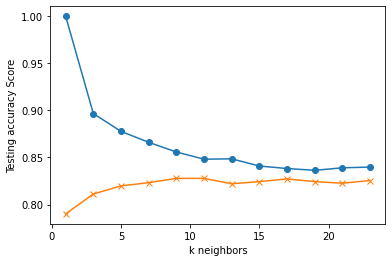

In [8]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
train_scores = []
test_scores = []
for k in range(1, 25, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 25, 2), train_scores, marker='o')
plt.plot(range(1, 25, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()



In [9]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_scaled, encoded_y_train)
predictions = knn.predict(X_test_scaled)
print(predictions)

print(f"k = 17: Training Data Score: {knn.score(X_train_scaled, encoded_y_train):.5f}")
print(f"k = 17: Testing Data Score: {knn.score(X_test_scaled, encoded_y_test):.5f}")

[2 0 2 ... 1 0 1]
k = 17: Training Data Score: 0.83826
k = 17: Testing Data Score: 0.82723


In [10]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(encoded_y_test, predictions, 
                            target_names = ["Confirmed", "False Positive", "Candidate"]))

                precision    recall  f1-score   support

     Confirmed       0.69      0.52      0.60       411
False Positive       0.67      0.79      0.72       484
     Candidate       0.98      1.00      0.99       853

      accuracy                           0.83      1748
     macro avg       0.78      0.77      0.77      1748
  weighted avg       0.83      0.83      0.82      1748



# Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [12]:
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors':[15, 17, 19],
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

grid = GridSearchCV(knn, param_grid, verbose=3)

In [13]:
# Train the model with GridSearch
grid.fit(X_train_scaled, encoded_y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] algorithm=auto, n_neighbors=15 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... algorithm=auto, n_neighbors=15, score=0.832, total=   0.2s
[CV] algorithm=auto, n_neighbors=15 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ...... algorithm=auto, n_neighbors=15, score=0.811, total=   0.2s
[CV] algorithm=auto, n_neighbors=15 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ...... algorithm=auto, n_neighbors=15, score=0.831, total=   0.2s
[CV] algorithm=auto, n_neighbors=15 ..................................
[CV] ...... algorithm=auto, n_neighbors=15, score=0.808, total=   0.2s
[CV] algorithm=auto, n_neighbors=15 ..................................
[CV] ...... algorithm=auto, n_neighbors=15, score=0.813, total=   0.2s
[CV] algorithm=auto, n_neighbors=17 ..................................
[CV] ...... algorithm=auto, n_neighbors=17, score=0.838, total=   0.2s
[CV] algorithm=auto, n_neighbors=17 ..................................
[CV] ...... algorithm=auto, n_neighbors=17, score=0.811, total=   0.2s
[CV] algorithm=auto, n_neighbors=17 ..................................
[CV] ...... algorithm=auto, n_neighbors=17, score=0.830, total=   0.2s
[CV] algorithm=auto, n_neighbors=17 ..................................
[CV] ...... algorithm=auto, n_neighbors=17, score=0.803, total=   0.2s
[CV] algorithm=auto, n_neighbors=17 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   13.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=17, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [15, 17, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [14]:
print(grid.best_params_)
print(grid.best_score_)

{'algorithm': 'auto', 'n_neighbors': 19}
0.82128217349857


# Save the Model

In [15]:
# save your model by updating "your_name" with your name
# and "your_model" with your model variable
# be sure to turn this in to BCS
# if joblib fails to import, try running the command to install in terminal/git-bash
import joblib
filename = 'knn.sav'
joblib.dump(knn, filename)

['knn.sav']